Author: Etienne Doumazane (Nicolas Renier's lab, Paris Brain Institute)

This notebook uses:
- An ontology JSONL file, as downloaded at https://raw.githubusercontent.com/ChristophKirst/ClearMap2/master/ClearMap/Resources/Atlas/ABA_annotation_last.jsonl
- Cell counts NPY files (1 per sample), as generated with `napari` in a separate notebook.

This notebook generates:
- 2 figures as SVG files
- the cell counts per region as CSV files (1 per sample)

# Imports and function definitions

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

In [2]:
def get_ontology_df_and_dicts(ontology_fpath: str | Path):
    """
    Creates util ontology dataframe and dictionnaries
    
    ontology_fpath: file path of the ontology file (JSONL file)
    # The ontology file can be downloaded here: 
        https://raw.githubusercontent.com/ChristophKirst/ClearMap2/master/ClearMap/Resources/Atlas/ABA_annotation_last.jsonl 
        You can use this command in a bash: 
        wget https://raw.githubusercontent.com/ChristophKirst/ClearMap2/master/ClearMap/Resources/Atlas/ABA_annotation_last.jsonl`
    """

    ontology_df = pd.read_json(ontology_fpath, lines=True)
    dict_colors = dict(zip(ontology_df.name, ontology_df.color_hex_triplet.map(lambda x: "#" + str(x))))
    dict_names = dict(zip(ontology_df.id, ontology_df.name))
    dict_ids = dict(zip(ontology_df.acronym, ontology_df.id))
    dict_orders = dict(zip(ontology_df.name, ontology_df.allen_brain_institute_order))

    # optional: metaregion
    metaregions = [dict_ids[acronym] for acronym in ["universe", "root", "Isocortex", "OLF", "HPF", "CTXsp", "STR", "PAL", "TH", "HY", "MB", "CB", "MY", "OLF", "P"]]
    # This line labels all structures with a "metaregion" from the list above. If there are several metaregions, it takes the deepest metaregion
    ontology_df["metaregion"] = ontology_df.structure_path.map(lambda x: [id for id in x if id in metaregions][-1] if len([id for id in x if id in metaregions]) > 0 else None).map(dict_names)
    dict_metaregions = dict(zip(ontology_df.name, ontology_df.metaregion))
    
    return ontology_df, dict_colors, dict_names, dict_names, dict_orders, dict_metaregions

In [3]:
def get_counts_df(cells_fpath: str | Path):
    """
    cells_fpath: file_path of the cell counts (NPY file)
    Note: needs `dict_colors`, `dict_metaregions`, `dict_orders` at module level, as generated by the `get_ontology_df_and_dicts` function
    """

    cells_df = pd.DataFrame(np.load(cells_fpath, allow_pickle=True))
    display(cells_df)
    counts_df = cells_df.groupby("name").size().sort_values(ascending=False).to_frame(name="count").reset_index()
    counts_df["color"] = counts_df["name"].map(dict_colors)
    counts_df["metaregion"] = counts_df["name"].map(dict_metaregions)
    counts_df["order"] = counts_df["name"].map(dict_orders)
    display(counts_df)
    display(counts_df[counts_df.isna().sum(axis=1) > 1])
    counts_df = counts_df.dropna()
    return counts_df

In [4]:
ontology_fpath = "~/code/ChristophKirst/ClearMap2/ClearMap/Resources/Atlas/ABA_annotation_last.jsonl"
ontology_df, dict_colors, dict_names, dict_names, dict_orders, dict_metaregions = get_ontology_df_and_dicts(ontology_fpath)

display(ontology_df)

,id,allen_brain_institute_order,acronym,name,color_hex_triplet,st_level,parent_structure_id,direct_children_structures_ids,all_children_structures_ids,structure_path,structure_ids_path,structure_acronyms_path,metaregion
0,0,-1,universe,universe,000000,NaN,NaN,[997],"[997, 8, 567, 688, 695, 315, 184, 68, 667, 526...",[0],0,universe,universe
1,997,0,root,root,FFFFFF,0.0,NaN,"[8, 1009, 73, 1024, 304325711]","[8, 1009, 73, 1024, 304325711, 567, 688, 695, ...",[997],997,root,root
2,8,1,grey,Basic cell groups and regions,BFDAE3,1.0,997.0,"[567, 343, 512]","[567, 343, 512, 688, 695, 315, 184, 68, 667, 5...","[997, 8]",997/8,root > grey,root
3,567,2,CH,Cerebrum,B0F0FF,2.0,8.0,"[688, 623]","[688, 623, 695, 315, 184, 68, 667, 526157192, ...","[997, 8, 567]",997/8/567,root > grey > CH,root
4,688,3,CTX,Cerebral cortex,B0FFB8,3.0,567.0,"[695, 703]","[695, 703, 315, 184, 68, 667, 526157192, 52615...","[997, 8, 567, 688]",997/8/567/688,root > grey > CH > CTX,root
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,49,1322,ipf,intraparafloccular fissure,AAAAAA,8.0,1040.0,[],[],"[997, 1024, 1040, 49]",997/1024/1040/49,root > grv > grv of CBX > ipf,root
1324,57,1323,pms,paramedian sulcus,AAAAAA,8.0,1040.0,[],[],"[997, 1024, 1040, 57]",997/1024/1040/57,root > grv > grv of CBX > pms,root
1325,65,1324,pfs,parafloccular sulcus,AAAAAA,8.0,1040.0,[],[],"[997, 1024, 1040, 65]",997/1024/1040/65,root > grv > grv of CBX > pfs,root
1326,624,1325,IPF,Interpeduncular fossa,AAAAAA,7.0,1024.0,[],[],"[997, 1024, 624]",997/1024/624,root > grv > IPF,root


# 1. Sample `452`

In [5]:
cells_fpath_452 = Path.home() / "Downloads/452.npy"

In [6]:
counts_df_452 = get_counts_df(cells_fpath_452)

,xt,yt,zt,order,name
0,246.435237,266.958943,24.671975,434,"Retrosplenial area, dorsal part, layer 2/3"
1,265.029190,285.625289,22.866993,610,"Retrosplenial area, dorsal part, layer 5"
2,245.965810,233.977027,38.907787,767,"Secondary motor area, layer 5"
3,259.093759,329.700556,23.968533,610,"Retrosplenial area, dorsal part, layer 5"
4,260.762971,296.244134,29.414038,610,"Retrosplenial area, dorsal part, layer 5"
...,...,...,...,...,...
1308,215.433324,204.917844,282.484966,117,optic chiasm
1309,266.213611,311.860260,264.622884,0,universe
1310,392.637415,345.939334,182.518587,382,Field CA1
1311,380.424063,387.477567,109.171312,312782656,No label


,name,count,color,metaregion,order
0,Zona incerta,177,#F2483B,Hypothalamus,802.0
1,Ventral medial nucleus of the thalamus,128,#FF8084,Thalamus,645.0
2,Hypothalamus,112,#E64438,Hypothalamus,715.0
3,Thalamus,104,#FF7080,Thalamus,641.0
4,Lateral hypothalamic area,47,#F2483B,Hypothalamus,794.0
...,...,...,...,...,...
151,optic nerve,1,#CCCCCC,root,1112.0
152,Ventral posteromedial nucleus of the thalamus,1,#FF8084,Thalamus,649.0
153,"Anterolateral visual area, layer 5",1,#08858C,Isocortex,168.0
154,"Agranular insular area, ventral part, layer 5",1,#219866,Isocortex,294.0


,name,count,color,metaregion,order
148,No label,1,NaN,NaN,NaN


In [7]:
# df = counts_df_452.head(25)
# display(df)
# sns.barplot(data=df, y="name", x="count", hue="name", palette=df["color"].to_list())

In [8]:
# df = counts_df_452.sort_values(["order"], ascending=False)
# plt.figure(figsize=(10, 30))
# sns.barplot(data=df, y="name", x="count", hue="name", palette=df["color"].to_list())

# 2. Sample `450`

In [9]:
cells_fpath_450 = Path.home() / "Downloads/450.npy"

In [10]:
counts_df_450 = get_counts_df(cells_fpath_450)

,xt,yt,zt,order,name
0,251.134782,337.123348,23.717220,610,"Retrosplenial area, dorsal part, layer 5"
1,254.127082,335.838686,25.979863,610,"Retrosplenial area, dorsal part, layer 5"
2,280.289030,312.840724,28.630869,774,"Retrosplenial area, lateral agranular part, la..."
3,271.906497,285.811063,29.440779,774,"Retrosplenial area, lateral agranular part, la..."
4,245.084273,251.533330,29.877629,434,"Retrosplenial area, dorsal part, layer 2/3"
...,...,...,...,...,...
2318,154.310006,244.473793,225.563962,342,Substantia innominata
2319,194.185207,257.731404,225.394987,1097,Hypothalamus
2320,170.077988,233.681987,223.525781,342,Substantia innominata
2321,138.688440,253.334514,217.887971,342,Substantia innominata


,name,count,color,metaregion,order
0,Zona incerta,230,#F2483B,Hypothalamus,802.0
1,Thalamus,178,#FF7080,Thalamus,641.0
2,Hypothalamus,176,#E64438,Hypothalamus,715.0
3,Ventral medial nucleus of the thalamus,160,#FF8084,Thalamus,645.0
4,Lateral hypothalamic area,115,#F2483B,Hypothalamus,794.0
...,...,...,...,...,...
186,"Primary somatosensory area, mouth, layer 6a",1,#188064,Isocortex,77.0
187,"Primary somatosensory area, trunk, layer 6a",1,#188064,Isocortex,91.0
188,"Primary somatosensory area, upper limb, layer 6a",1,#188064,Isocortex,84.0
189,Principal sensory nucleus of the trigeminal,1,#FFAE6F,Pons,889.0


,name,count,color,metaregion,order
77,No label,4,NaN,NaN,NaN


In [11]:
# df = counts_df_450.head(25)
# display(df)
# sns.barplot(data=df, y="name", x="count", hue="name", palette=df["color"].to_list())


In [12]:
# df = counts_df_450.sort_values(["order"], ascending=False)
# plt.figure(figsize=(10, 30))
# sns.barplot(data=df, y="name", x="count", hue="name", palette=df["color"].to_list())

# 3. Both sample together

,name,count,sample,mean,allen_brain_institute_order,color,acronym
0,universe,14,452,12.0,-1,#000000,universe
1,universe,10,450,12.0,-1,#000000,universe
2,"Primary motor area, Layer 5",10,450,9.5,21,#1F9D5A,MOp5
3,"Primary motor area, Layer 5",9,452,9.5,21,#1F9D5A,MOp5
4,"Primary motor area, Layer 6a",7,452,10.5,22,#1F9D5A,MOp6a
...,...,...,...,...,...,...,...
340,habenular commissure,2,452,2.0,1287,#CCCCCC,hbc
341,ventricular systems,1,452,1.0,1292,#AAAAAA,VS
342,third ventricle,2,450,3.5,1299,#AAAAAA,V3
343,third ventricle,5,452,3.5,1299,#AAAAAA,V3


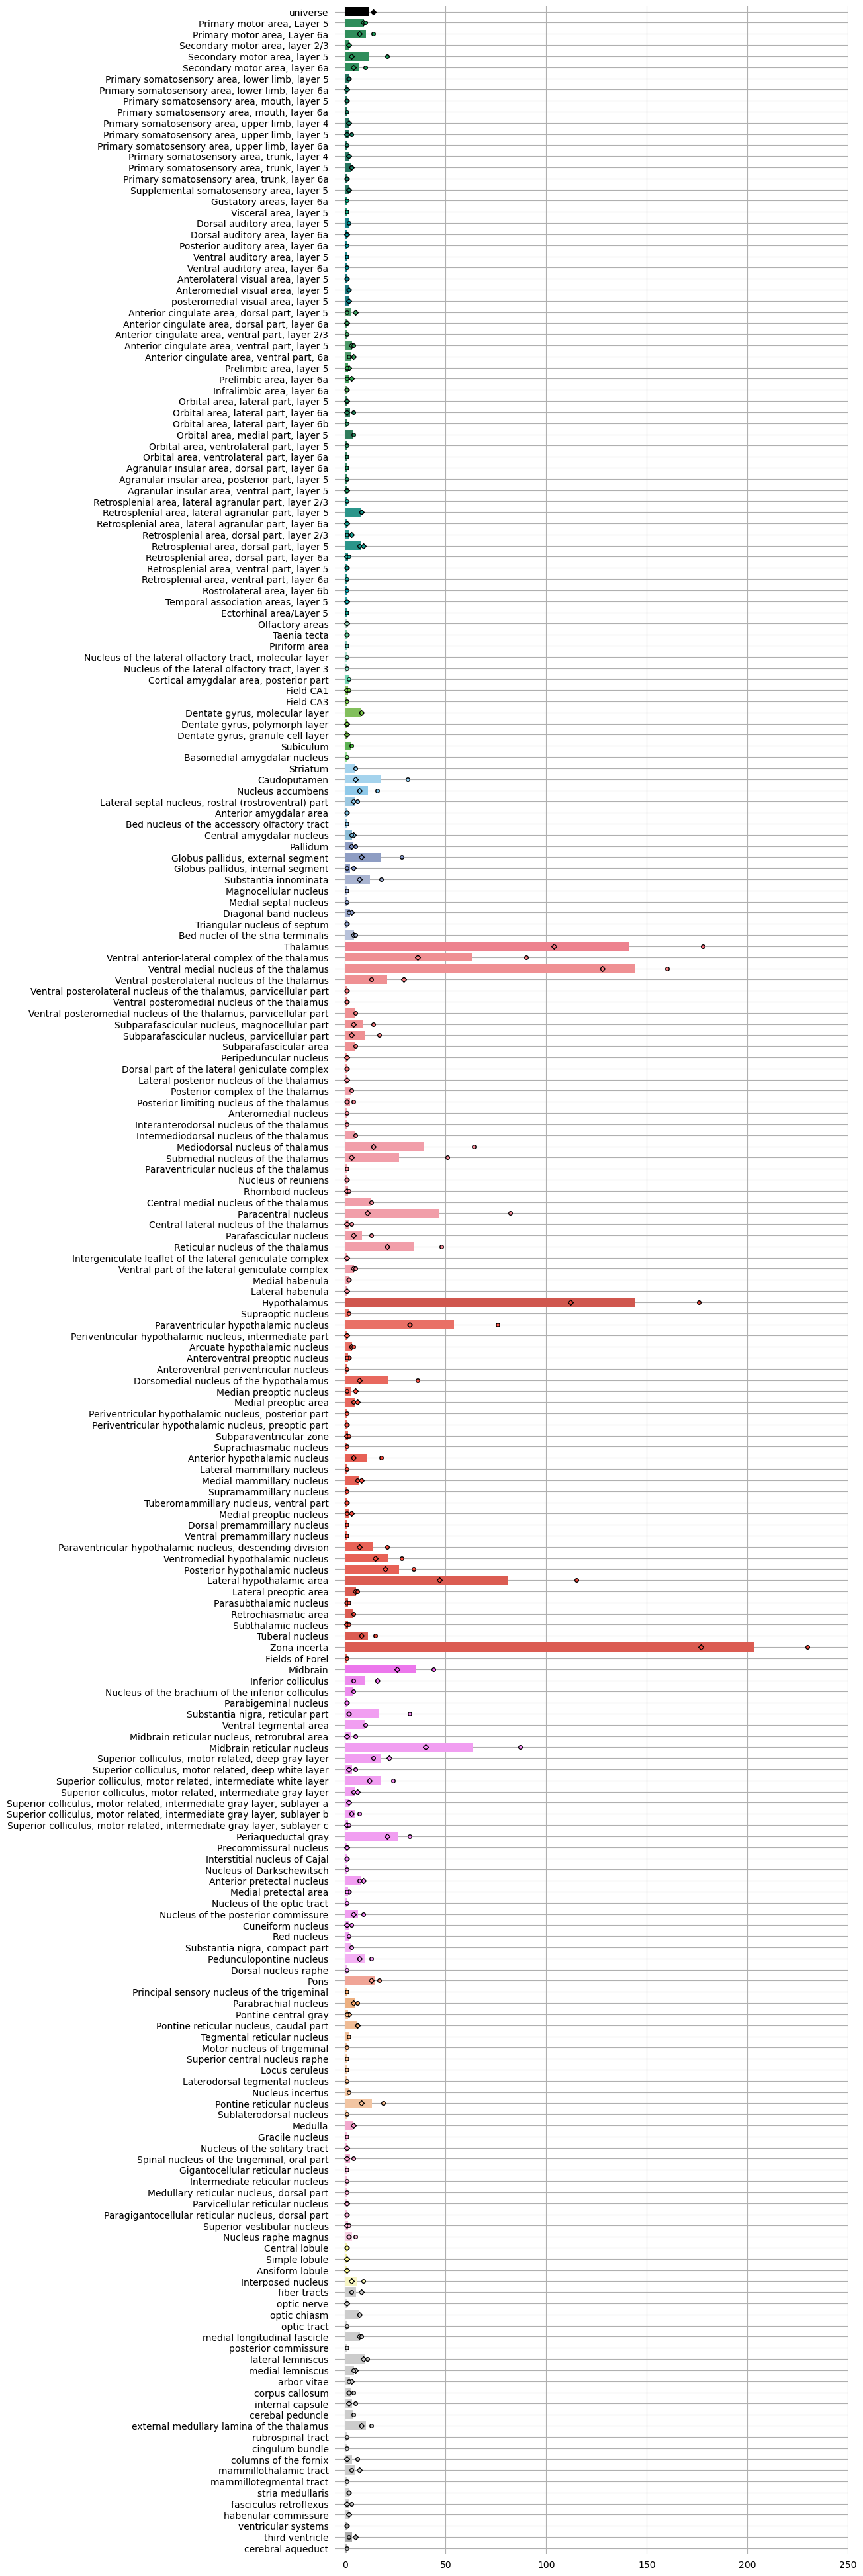

In [13]:
df = counts_df_452[["name", "count"]].copy()
df = df.merge(counts_df_452[["name"]], on="name", how="outer").fillna(0)
df["sample"] = "452"

df_2 = counts_df_450[["name", "count"]].copy()
df_2 = df_2.merge(counts_df_450[["name"]], on="name", how="outer").fillna(0)
df_2["sample"] = "450"

df = pd.concat([df, df_2])
df = df.merge(df.groupby("name")["count"].mean().to_frame("mean"), on="name")
df = df.merge(ontology_df[["name", "allen_brain_institute_order", "color_hex_triplet", "acronym"]], on="name").sort_values("allen_brain_institute_order").reset_index(drop=True).rename(columns={"color_hex_triplet": "color"})
df["color"] = "#" + df["color"]

display(df)

plt.figure(figsize=(10, 50))
sns.barplot(data=df, y="name", x="count", hue="name", palette=df[["name", "color"]].drop_duplicates("name")["color"].to_list(), errorbar=None, )
sns.stripplot(data=df.query("sample == '452'"), y="name", x="count", hue="name", palette=df.query("sample == '452'")["color"].to_list(), jitter=False, marker="D", size=4, edgecolor="black", linewidth=1, )
sns.stripplot(data=df.query("sample == '450'"), y="name", x="count", hue="name", palette=df.query("sample == '450'")["color"].to_list(), jitter=False, marker="o", size=4, edgecolor="black", linewidth=1, )
plt.grid()
plt.xlim(left=-5, right=250)
sns.despine(left=True, bottom=True)
plt.tick_params(bottom=False, left=False)
plt.gca().set_axisbelow(True)
plt.ylabel("")
plt.xlabel("")
plt.savefig("figure.svg", bbox_inches="tight");

,name,count,sample,mean,allen_brain_institute_order,color,acronym
0,Zona incerta,177,452,203.5,802,#F2483B,ZI
1,Zona incerta,230,450,203.5,802,#F2483B,ZI
2,Ventral medial nucleus of the thalamus,160,450,144.0,645,#FF8084,VM
3,Hypothalamus,176,450,144.0,715,#E64438,HY
4,Hypothalamus,112,452,144.0,715,#E64438,HY
5,Ventral medial nucleus of the thalamus,128,452,144.0,645,#FF8084,VM
6,Thalamus,178,450,141.0,641,#FF7080,TH
7,Thalamus,104,452,141.0,641,#FF7080,TH
8,Lateral hypothalamic area,115,450,81.0,794,#F2483B,LHA
9,Lateral hypothalamic area,47,452,81.0,794,#F2483B,LHA


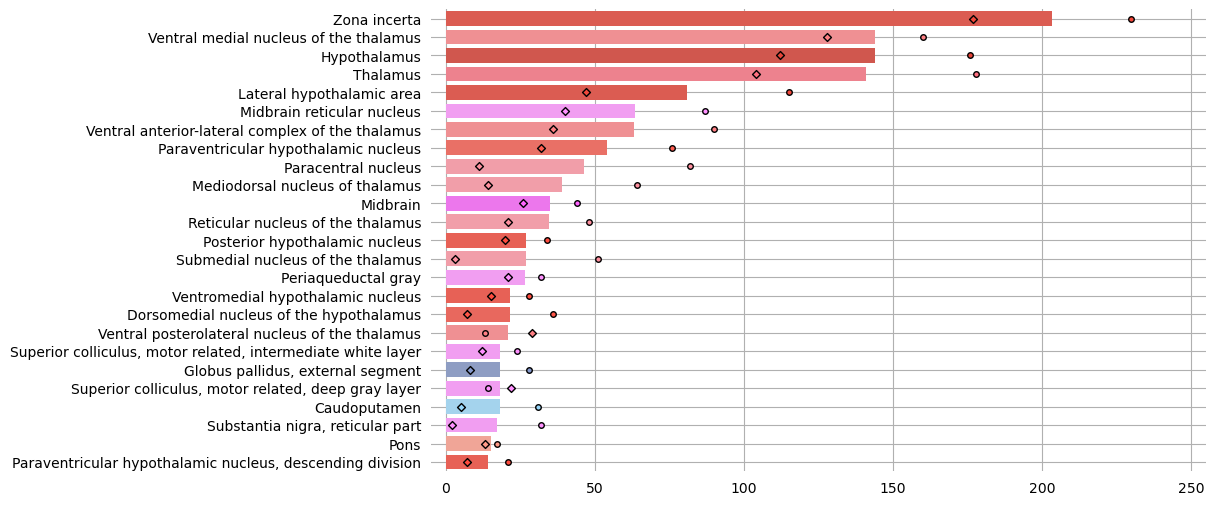

In [14]:
df = counts_df_452[["name", "count"]].copy()
df = df.merge(counts_df_452[["name"]], on="name", how="outer").fillna(0)
df["sample"] = "452"

df_2 = counts_df_450[["name", "count"]].copy()
df_2 = df_2.merge(counts_df_450[["name"]], on="name", how="outer").fillna(0)
df_2["sample"] = "450"

df = pd.concat([df, df_2])
df = df.merge(df.groupby("name")["count"].mean().to_frame("mean"), on="name")
df = df.merge(ontology_df[["name", "allen_brain_institute_order", "color_hex_triplet", "acronym"]], on="name").rename(columns={"color_hex_triplet": "color"})
df["color"] = "#" + df["color"]
df = df.sort_values("mean", ascending=False).reset_index(drop=True).head(50)

display(df)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, y="name", x="count", hue="name", palette=df[["name", "color"]].drop_duplicates("name")["color"].to_list(), errorbar=None, )
sns.stripplot(data=df.query("sample == '452'"), y="name", x="count", hue="name", palette=df.query("sample == '452'")["color"].to_list(), jitter=False, marker="D", size=4, edgecolor="black", linewidth=1, )
sns.stripplot(data=df.query("sample == '450'"), y="name", x="count", hue="name", palette=df.query("sample == '450'")["color"].to_list(), jitter=False, marker="o", size=4, edgecolor="black", linewidth=1, )
plt.grid()
plt.xlim(left=-5, right=255)
sns.despine(left=True, bottom=True)
plt.tick_params(bottom=False, left=False)
plt.gca().set_axisbelow(True)
plt.ylabel("")
plt.xlabel("")
plt.savefig("figure_2.svg", bbox_inches="tight");

# 4. Count table

In [15]:
fname = "counts_by_structure.csv"

df_452 = counts_df_452[["name", "count"]].rename(columns=dict(count="sample_452"))
df_450 = counts_df_450[["name", "count"]].rename(columns=dict(count="sample_450"))

df = df_452.merge(df_450, on="name", how="outer").fillna(0)
df[["sample_452", "sample_450"]] = df[["sample_452", "sample_450"]].astype(int)
df.index = df["name"].map(dict_orders)
df = df.sort_index().reset_index(drop=True)

display(df)
df.to_csv(fname)

,name,sample_452,sample_450
0,universe,14,10
1,"Primary motor area, Layer 5",9,10
2,"Primary motor area, Layer 6a",7,14
3,"Secondary motor area, layer 2/3",2,0
4,"Secondary motor area, layer 5",3,21
...,...,...,...
224,fasciculus retroflexus,1,3
225,habenular commissure,2,0
226,ventricular systems,1,0
227,third ventricle,5,2
